In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy
import scipy.io as sio
import torch

from tqdm import tqdm
from datetime import datetime
from src.RL_functions.generate_synthetic_time_series import *

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_tagiV import regime_change_detection_tagiV

from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
from examples.data_loader import SyntheticTimeSeriesDataloader

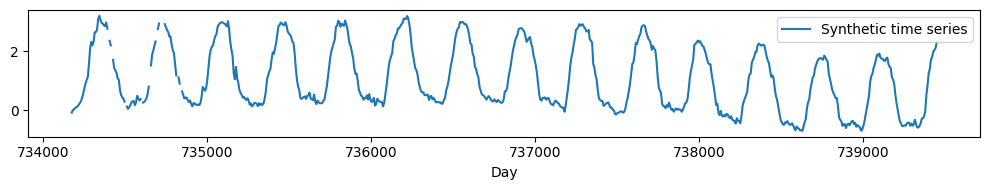

In [2]:
# Import data HQ TS2
time_series_path = './data/HQ/CASC_LGA007PIAP_E010_2024_07.mat'
data = sio.loadmat(time_series_path)
timestamps = data['values'][:, 1][0].T[0][368:]
y_disp = data['values'][:, 3][0].T[0][368:].tolist()
time_covariates = ['week_of_year']
obs_file_paths = ['data/CASC_LGA007PIAP_E010_2024_07/ytrain_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_obs.csv']
date_file_paths=['data/CASC_LGA007PIAP_E010_2024_07/ytrain_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_datetime.csv']

data_preprocessor = generate_one_synthetic_time_series(used_for_generation=False)
data_preprocessor.time_series['y'] = y_disp
data_preprocessor.time_series['timesteps'] = timestamps
data_preprocessor.time_step_interval = 7
data_preprocessor.export_to_csv(indices_train_val_test=[216, 268, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2010, 2, 7, 12, 0, 0))
val_datetime_values = data_preprocessor.get_validation_datetime_values()
data_preprocessor.plot()

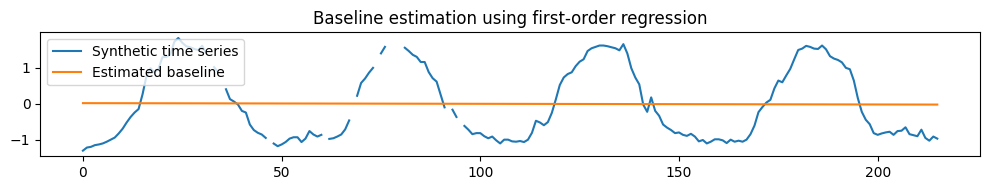

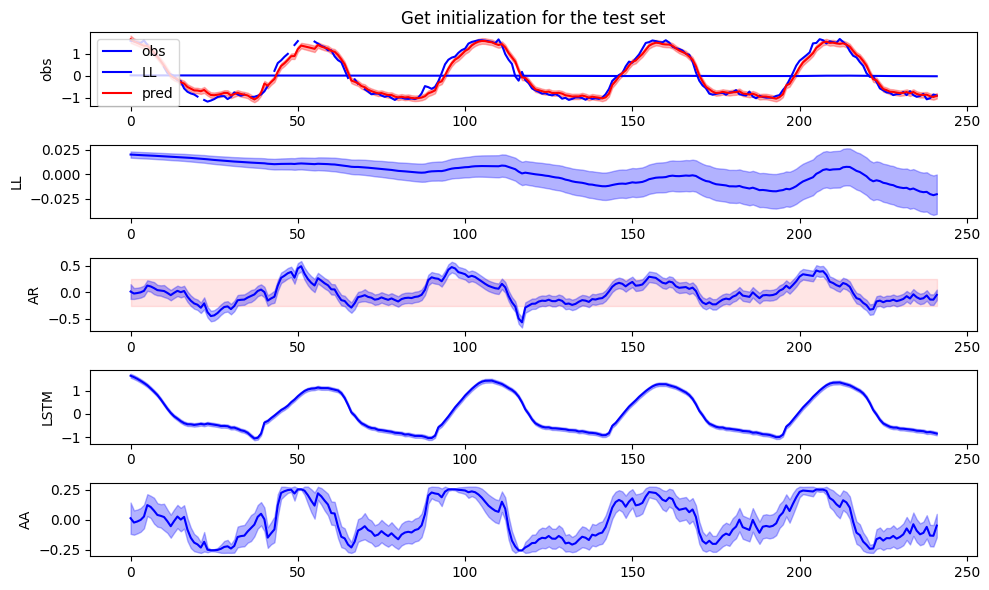

In [3]:
num_epochs: int = 30
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    components = 'LT + BAR + ITV + AR',
                    use_BAR = True,
                    input_BAR = [2, -2, 2],
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

BDLM.phi_AR = 0.7149851524192852
BDLM.Sigma_AR = 0.008007963607039528
BDLM.var_phi_AR = 0.003201778390741798
BDLM.var_Sigma_AR = 3.1053512166112148e-06

BDLM.load_LSTM_model(path = './saved_param/CASC_LGA007PIAP_E010_2024_07/lstm_y_V3_int.pth')

initial_z = np.array([BDLM.level_init, BDLM.speed_init, 0, 0, 0.02])
initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.15**2])
LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True,
                                                                               initial_z = initial_z, initial_Sz = initial_Sz)

In [4]:
step_look_back = 64
anm_pos = 150
train_dtl = SyntheticTimeSeriesDataloader(
                    x_file='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_observation_1000episodes.csv',
                    select_column=10,
                    date_time_file='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_datetime_1000episodes.csv',
                    add_anomaly = True,
                    anomaly_magnitude=[0.03, -0.03],
                    anomaly_start=anm_pos,
                    x_mean=BDLM.train_dtl.x_mean,
                    x_std=BDLM.train_dtl.x_std,
                    output_col=BDLM.output_col,
                    input_seq_len=BDLM.input_seq_len,
                    output_seq_len=BDLM.output_seq_len,
                    num_features=BDLM.num_features,
                    stride=BDLM.seq_stride,
                    time_covariates=BDLM.time_covariates,
                )


env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl,\
                    ts_model=BDLM.model, step_look_back=step_look_back) # Data loader options: BDLM.test_dtl or train_dtl
state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
                        net_test = BDLM.net_test, init_mu_W2b = None, init_var_W2b = None, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                        phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio, use_BAR = BDLM.use_BAR, input_BAR = BDLM.input_BAR)

intervention_index =[]
AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))

from itertools import count
for t in count():
    action = 0
    if t == anm_pos + 50 - 64:
        action = 1
    _, _, terminated, truncated, info = env.step(action, cost_intervention=0)

    if action == 1:
        intervention_index.append(t + step_look_back + 1)

    done = terminated or truncated
    if done:
        break

timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

(442, 1000)


/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_74287/3581096421.py:32: RuntimeWarning: invalid value encountered in sqrt
  ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-4] - np.sqrt(var_hidden_states_one_episode[:,-4,-4]), mu_hidden_states_one_episode[:,-4] + np.sqrt(var_hidden_states_one_episode[:,-4,-4]), color='blue', alpha=0.3, label='±1 SD')


Text(0, 0.5, 'delta')

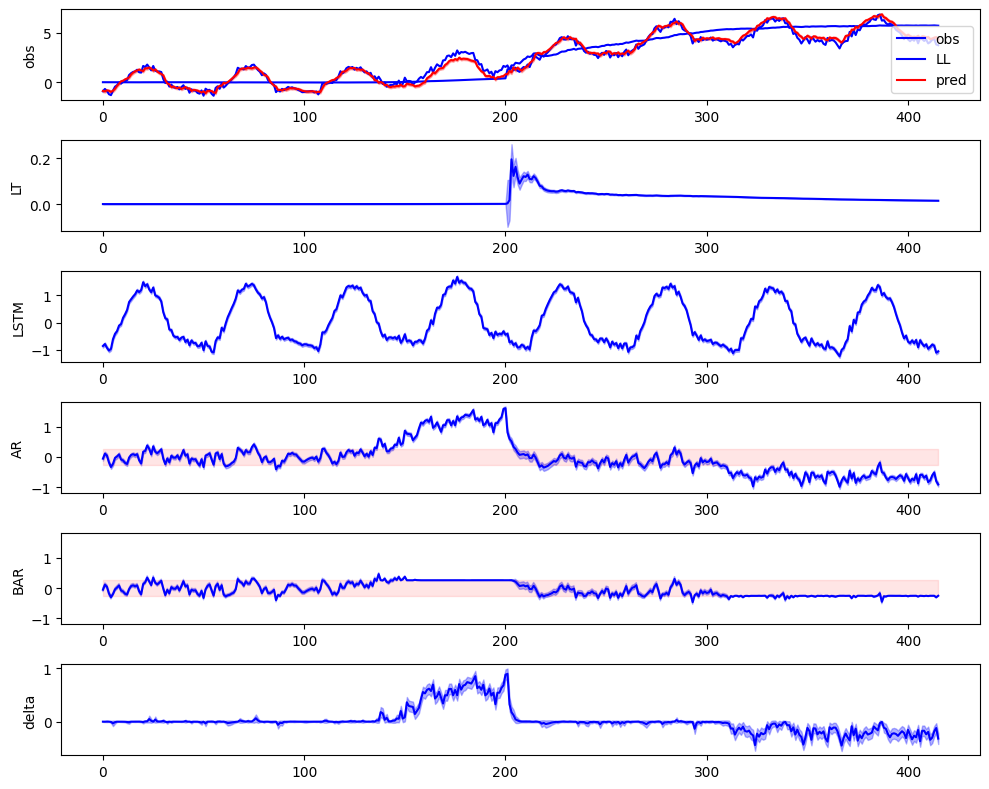

In [5]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

ax0.plot(timesteps, info['measurement_one_episode'],color='b',label=r"obs")
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0],color='b',label=r"LL")
ax0.plot(timesteps, mu_prediction_one_episode,color='r',label=r"pred")
ax0.fill_between(timesteps, mu_prediction_one_episode - np.sqrt(var_prediction_one_episode), mu_prediction_one_episode + np.sqrt(var_prediction_one_episode), color='red', alpha=0.3)
ax0.set_ylabel('obs')
ax0.legend()

ax1.plot(timesteps,mu_hidden_states_one_episode[:,1],color='b',label=r"LT")
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]), mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='blue', alpha=0.3, label='±1 SD')
ax1.set_ylabel('LT')

ax2.plot(timesteps,mu_hidden_states_one_episode[:,-1],color='b',label=r"LSTM")
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]), mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='blue', alpha=0.3, label='±1 SD')
ax2.set_ylabel('LSTM')

ax3.plot(timesteps,mu_hidden_states_one_episode[:,-2],color='b',label=r"AR")
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]), mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='blue', alpha=0.3, label='±1 SD')
ax3.fill_between(timesteps, np.zeros_like(timesteps)-2*AR_std_stationary, np.zeros_like(timesteps)+2*AR_std_stationary, color='red', alpha=0.1)
ax3.set_ylabel('AR')
# ax3.set_ylim(-1.1, 1.1)

ax4.plot(timesteps,mu_hidden_states_one_episode[:,-4],color='b',label=r"BAR")
ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-4] - np.sqrt(var_hidden_states_one_episode[:,-4,-4]), mu_hidden_states_one_episode[:,-4] + np.sqrt(var_hidden_states_one_episode[:,-4,-4]), color='blue', alpha=0.3, label='±1 SD')
ax4.fill_between(timesteps, np.zeros_like(timesteps)-2*AR_std_stationary, np.zeros_like(timesteps)+2*AR_std_stationary, color='red', alpha=0.1)
ax4.set_ylim(ax3.get_ylim())
ax4.set_ylabel('BAR')

ax5.plot(timesteps,mu_hidden_states_one_episode[:,-3],color='b',label=r"delta")
ax5.fill_between(timesteps, mu_hidden_states_one_episode[:,-3] - np.sqrt(var_hidden_states_one_episode[:,-3,-3]), mu_hidden_states_one_episode[:,-3] + np.sqrt(var_hidden_states_one_episode[:,-3,-3]), color='blue', alpha=0.3, label='±1 SD')
ax5.set_ylabel('delta')